In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import shap
from umap import UMAP
from astartes import train_test_split
from permetrics import ClusteringMetric

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    mean_absolute_error, root_mean_squared_error, r2_score
)

## Data Loading

In [2]:
df = pd.read_csv("../data/gold-features.csv")
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,file_name,energy
0,8.312640,0.013240,0.002026,0.000578,0.000059,0.000005,3.614525e-07,2.891632e-08,3.363042e-09,9.584413e-11,0.xyz,-1547.657785
1,8.903285,0.026071,0.002458,0.000283,0.000031,0.000006,1.041832e-06,4.556548e-08,2.465568e-09,8.548989e-11,1.xyz,-1552.612539
2,9.287031,0.033807,0.002167,0.000183,0.000028,0.000006,1.474569e-06,6.771517e-08,1.839670e-09,8.525103e-11,10.xyz,-1555.417784
3,8.923366,0.023786,0.001960,0.000339,0.000035,0.000007,9.650267e-07,5.893078e-08,2.394213e-09,1.202439e-10,100.xyz,-1552.217633
4,9.086140,0.026782,0.001243,0.000245,0.000049,0.000005,1.253184e-06,4.471700e-08,3.935182e-09,1.254421e-10,101.xyz,-1552.886542


In [3]:
X = df.iloc[:, :10].values
y = df["energy"].values

X.shape, y.shape

((999, 10), (999,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, sampler="kennard_stone", train_size=0.80, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((799, 10), (200, 10), (799,), (200,))

## Modelling

In [5]:
preprocessor = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=6)),
])

X_train_pca = preprocessor.fit_transform(X_train)
X_test_pca = preprocessor.transform(X_test)
X_pca = preprocessor.transform(X)

In [6]:
model = XGBRegressor(
    random_state=21,
    booster="gbtree",
    tree_method="exact",
    n_estimators=100,
    max_depth=  4,
    eta=0.1136823210285093,
    reg_alpha=0.06671740722713554,
    reg_lambda=.010881414799327853,
    colsample_bytree=0.9702171387228603,
    subsample=0.7179234799654054,
)

model.fit(X_train_pca, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9702171387228603
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
y_preds = model.predict(X_test_pca)

print("MAE", mean_absolute_error(y_test, y_preds))
print("RMSE", root_mean_squared_error(y_test, y_preds))
print("R2", r2_score(y_test, y_preds))

MAE 0.2763549641796874
RMSE 0.3650635145118939
R2 0.9842256429955737


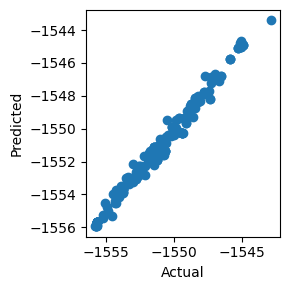

In [8]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(y_preds, y_test)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")

fig.tight_layout()
plt.show()

## Statistical Tests

In [9]:
sp.stats.ttest_ind(y_test, y_preds)

TtestResult(statistic=np.float64(-0.19264387191286375), pvalue=np.float64(0.8473361440093348), df=np.float64(398.0))

In [10]:
sp.stats.ks_2samp(y_test, y_preds)

KstestResult(statistic=np.float64(0.075), pvalue=np.float64(0.6284308022715471), statistic_location=np.float64(-1551.880711), statistic_sign=np.int8(1))

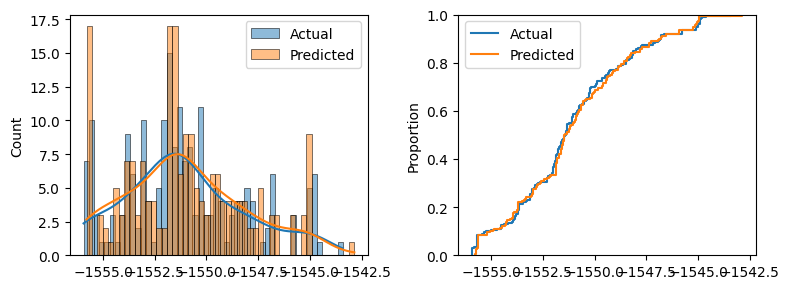

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

sns.histplot(y_test, bins=50, kde=True, ax=ax1, label="Actual")
sns.histplot(y_preds, bins=50, kde=True, ax=ax1, label="Predicted")
ax1.legend()

sns.ecdfplot(y_test, ax=ax2, label="Actual")
sns.ecdfplot(y_preds, ax=ax2, label="Predicted")
ax2.legend()

fig.tight_layout()
plt.show()

## SHAP

In [12]:
explainer = shap.TreeExplainer(model)
explanations = explainer(X_pca)
explanations.feature_names = [f"PC {i+1}" for i in range(X_pca.shape[1])]

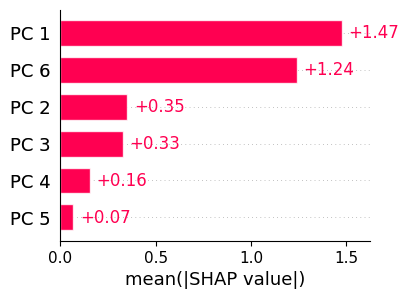

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
shap.plots.bar(explanations, ax=ax)
plt.show()

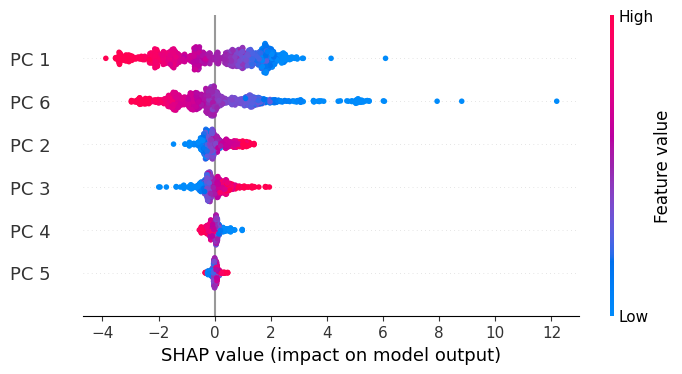

In [14]:
shap.plots.beeswarm(explanations)

## Dimension Reduction

In [15]:
umap_fit = UMAP(n_components=2, min_dist=0.1, n_neighbors=15, random_state=21)
umap_data = umap_fit.fit_transform(explanations.values)

/home/ramiel/research/gold-cluster-energy-modelling/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


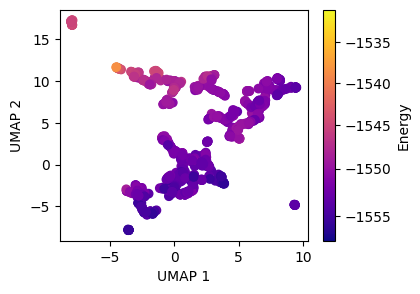

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))

sc = ax.scatter(umap_data[:, 0], umap_data[:, 1], c=df["energy"], cmap="plasma", 
                norm=colors.PowerNorm(gamma=0.9))
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

fig.colorbar(sc, ax=ax, label='Energy')
plt.show()

## Clustering

In [17]:
dbs = DBSCAN(eps=1.7, min_samples=10)
dbs.fit(umap_data)

,eps,1.7
,min_samples,10
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


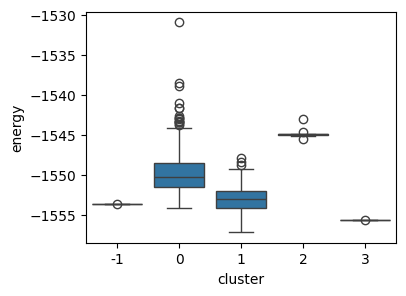

In [18]:
df_energy = pd.DataFrame({
    "umap_1": umap_data[:, 0],
    "umap_2": umap_data[:, 1],
    "file_name": df["file_name"],
    "energy": df["energy"],
    "cluster": dbs.labels_,
})

fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(df_energy, x="cluster", y="energy", ax=ax)
plt.show()

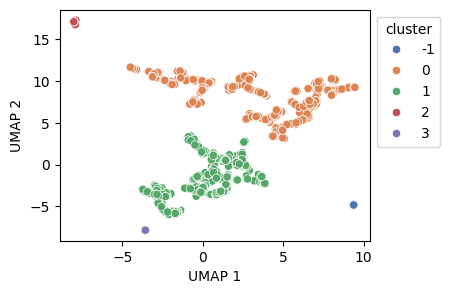

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.scatterplot(df_energy, x="umap_1", y="umap_2", hue="cluster", palette="deep", ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

plt.show()

In [ ]:
evaluator = ClusteringMetric()

print(f"Silhouette score: {evaluator.silhouette_index(umap_data, dbs.labels_):.4f}")
print(f"Calinshki-Harabasz score: {evaluator.calinski_harabasz_index(umap_data, dbs.labels_):.4f}")
print(f"DBI score: {evaluator.davies_bouldin_index(umap_data, dbs.labels_):.4f}")
print(f"DBCV score: {evaluator.density_based_clustering_validation_index(umap_data, dbs.labels_):.4f}")

Silhouette score: 0.42769619822502136
VRC score: 616.9743041992188
DBI score: 0.4579127221189573
